# Lower Star Image Filtrations

In this module, we will explore the lower star filtration, or "sublevelset filtration," on image data.  This will allow us to express local mins (or maxes if flipped) as birth times and saddle points as death times in a 0D persistence diagram, which is a useful and provably stable way of summarizing critical points in an image.

First, we do all of the necessary imports

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ripser import ripser, plot_dgms
import scipy.sparse as sparse
from scipy import ndimage
import imageio

We now define a function which constructs a 0D lower star filtration on an image.  It constructs a sparse distance matrix in which every pixel in the image is a vertex, and every vertex is connected to its 8 spatial neighbors (unless it's at the boundary, in which case there may be fewer).  The edge weights are taken to be the maximum of the two pixel values they connect (hence the "lower star").  In spite of the large number of pixels, this code will be fast (nearly linear in the number of pixels), as there are a linear number of edges in the number of pixels, and only 0D homology is computed, which uses union find.  Code is below:

In [2]:
def doImageSublevelsetFiltration(D):
    """
    Construct a lower star filtration on an image
    Parameters
    ----------
    D: ndarray (M, N)
        An array of image data
    Returns
    -------
    I: ndarray (K, 2)
        A 0D persistence diagram corresponding to the sublevelset filtration
    """
    idxs = np.arange(D.shape[0]*D.shape[1])
    idxs = np.reshape(idxs, D.shape)
    I = idxs.flatten()
    J = idxs.flatten()
    V = D.flatten()
    # Do 8 spatial neighbors
    tidxs = np.nan*np.ones((D.shape[0]+2, D.shape[1]+2), dtype=np.int64)
    tidxs[1:-1, 1:-1] = idxs
    tD = np.nan*np.ones_like(tidxs)
    tD[1:-1, 1:-1] = D
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            thisJ = np.roll(tidxs, di, axis=0)
            thisJ = np.roll(thisJ, dj, axis=1)
            thisD = np.roll(tD, di, axis=0)
            thisD = np.roll(thisD, dj, axis=1)
            thisD = np.maximum(thisD, tD)
            # Deal with boundaries
            thisI = tidxs[np.isnan(thisD)==0]
            thisJ = thisJ[np.isnan(thisD)==0]
            thisD = thisD[np.isnan(thisD)==0]
            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))
    sparseDM = sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))
    return ripser(sparseDM, distance_matrix=True, maxdim=0)['dgms'][0]

## Gaussian Blob Example

Now, let's test out this code on an example with an image containing some Gaussian blobs.  We will put three negative Gaussians in this image; one which reaches its local min at -3, one at -2, and one at -1:

<IPython.core.display.Javascript object>


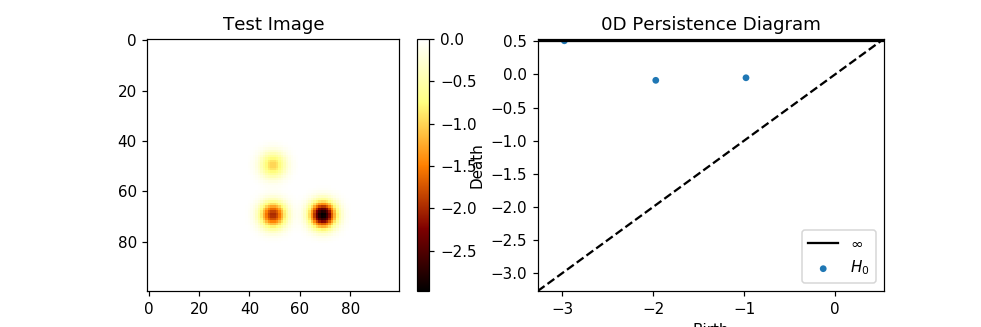

In [3]:
ts = np.linspace(-1, 1, 100)
x1 = np.exp(-ts**2/(0.1**2))
ts -= 0.4
x2 = np.exp(-ts**2/(0.1**2))
D = -x1[None, :]*x1[:, None] - 2*x1[None, :]*x2[:, None] - 3*x2[None, :]*x2[:, None]
I = doImageSublevelsetFiltration(D)

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(D, cmap = 'afmhot')
plt.colorbar()
plt.title("Test Image")
plt.subplot(122)
plot_dgms(I)
plt.title("0D Persistence Diagram")
plt.show()

As can be seen in this example, there are three dots corresponding to each of the 3 Gaussians, each of which is born at the respective local min.  Two of them die at around 0 where they meet other classes at saddle points, and the one born at -3 absorbs the other ones and lives forever (the "elder rule")

## Cell Biology Image Example

Let's now look at a slightly more exciting example.  We'll analyze the following creative commons image of plant cells, taken from <a href = "https://www.flickr.com/photos/146824358@N03/35486476174">this link</a>


<img src = "Cells.jpg">


When we convert this image to grayscale in the range $[0, 255]$, where $0$ is dark and $255$ is bright, we see that the interiors of the cells are around $1$, while each cell meets at a saddle point somewhere on the boundary, which is closer to $0$.  In this case, we posit that there is a *local max* of large persistence within each cell; that is, we want to perform a *superlevelset / upper star* filtration.  To hack our code so that it works for local maxes instead of local mins, we can simply feed the lower star filtration function the negative of the image.  Let's do this now and plot the lifetimes:

<IPython.core.display.Javascript object>


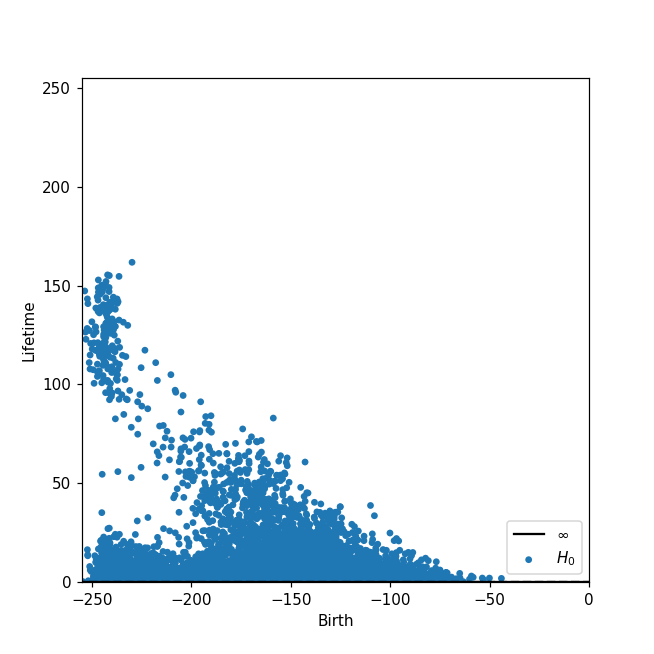

In [4]:
FOrig = imageio.imread("Cells.jpg")
F = np.dot(FOrig[...,:3], [0.299, 0.587, 0.114]) # Convert to grayscale
I = doImageSublevelsetFiltration(-F)

plt.figure(figsize=(6, 6))
plot_dgms(I, lifetime=True)
plt.xlim([-255, 0])
plt.ylim([0, 255])
plt.show()

Let's now pick a persistence threshold, above which we consider a dot to be associated to a cell.  Our ripser wrapper does not currently return representatives for 0D homology classes, but we can do a little hack where we add a small amount of uniform noise to each pixel.  This makes every pixel have a unique value, so we can simply find the pixel whose value is equal to the birth time of the class we're looking for.  We also perform a local averaging before we do this to encourage the representatives of the maxes to be closer to the center of the cell.  Let's try that below by looking at all of the dots with lifetime $\geq 70$, and superimposing their representatives over the original image:

<IPython.core.display.Javascript object>


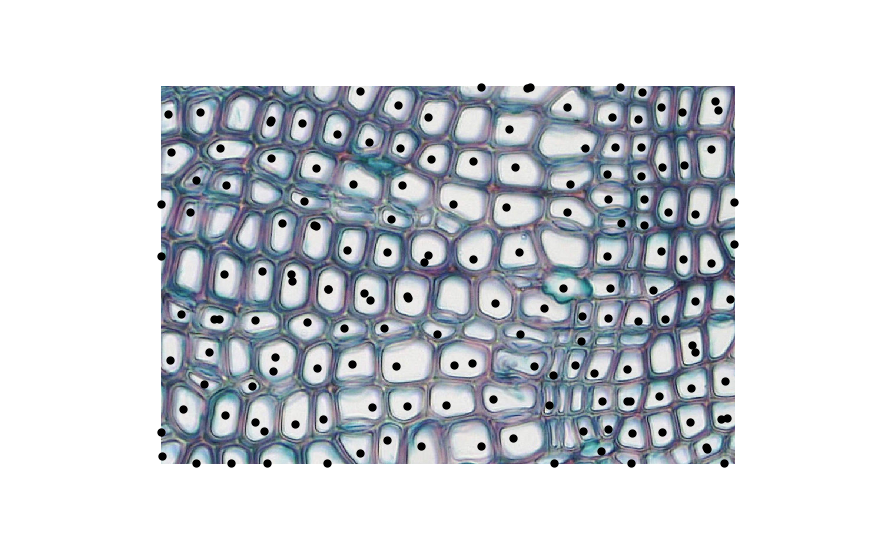

In [5]:
F = np.dot(FOrig[...,:3], [0.299, 0.587, 0.114])
F = ndimage.uniform_filter(F, size=10)
F += 0.01*np.random.randn(F.shape[0], F.shape[1])
I = doImageSublevelsetFiltration(-F)
thresh = 70
idxs = np.arange(I.shape[0])
idxs = idxs[np.abs(I[:, 1] - I[:, 0]) > thresh]

plt.figure(figsize=(8, 5))
plt.imshow(FOrig)
X, Y = np.meshgrid(np.arange(F.shape[1]), np.arange(F.shape[0]))
X = X.flatten()
Y = Y.flatten()
for idx in idxs:
    bidx = np.argmin(np.abs(F + I[idx, 0]))
    plt.scatter(X[bidx], Y[bidx], 20, 'k')
plt.axis('off')

plt.show()

The threshold can certainly be tweaked, but we see reasonably good results even with these choices.  There is about one max per cell; some have duplicates, and others are missing, but overall this naive approach does a good job of identifying the cells even though they have very different shapes.